In [1]:
# Perform PCA on SOMA forward data
import numpy as np
from sklearn.decomposition import PCA
import h5py

In [3]:
class ChannelScaler:
    def __init__(self) -> None:
        pass
    def centering(self, data, axis=1):
        m_ = np.mean(data, axis=axis, keepdims=True)
        std_ = np.std(data, axis=axis, keepdims=True)
        mask = std_ == 0

        self.m_ = m_
        self.std_ = std_

        std_[mask] = 1
        return (data - m_) / std_
    def transform(self, x):
        return (x - self.m_) / self.std_
    
    def inverse_transform(self, x):
        return x * self.std_ + self.m_

def channel_pca(data):
    batch = data.shape[0]
    ch = data.shape[-1]
    data_pca = data.reshape(batch, -1, ch)
    PCAs = []
    for i in range(ch):
        pca = PCA(n_components=50)
        pca.fit(data_pca[...,i])
        PCAs.append(pca)

    return PCAs


In [4]:
# load dataset and perform pCA
# note that since the datasize is large, the covariance matrices should be estimated using subsamples from the training set
# choose the first 3 forward runs as the subsamples for PCA

data = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/varyGM/thedataset3.hdf5', 'r')
data_pca = [data['forward_0'][...], data['forward_1'][...], data['forward_2'][...]]
data_pca = np.concatenate(data_pca, axis=0)



print(data_pca.shape)


(90, 60, 100, 100, 17)


(90, 60, 100, 100, 17)


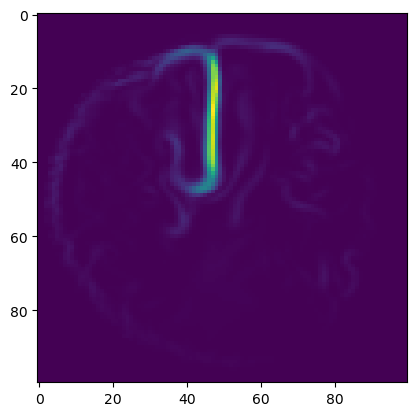

In [6]:
# apply mask and set 0 to outside boundary
import pickle
with open('../tmp/SOMA_mask.pkl', 'rb') as f:
    mask = pickle.load(f)
mask = ~np.logical_or(mask['mask1'], mask['mask2'])[0:1,0:1,:,:,0:1]
mask = mask.astype(int)
data_pca = data_pca * mask
print(data_pca.shape)
import matplotlib.pyplot as plt
plt.imshow(data_pca[0, 0,:,:,2].T)
plt.show()

In [7]:
# flatten the data 
data_pca_flatten = data_pca.reshape(data_pca.shape[0], -1)
print(data_pca_flatten.shape)

(90, 10200000)


In [5]:
# zero center the data 
from sklearn.preprocessing import StandardScaler as sc
scaler = sc()
data_pca_centered = scaler.fit_transform(data_pca_flatten)

NameError: name 'data_pca_flatten' is not defined

In [10]:
# perform pca

# pca = PCA(n_components=90)
# pca.fit(data_pca_centered)
# print(pca.explained_variance_ratio_)
cs = ChannelScaler()
print(np.isnan(data_pca).any())
centered_data = cs.centering(data_pca, axis=(0,1,2,3))
print(np.isnan(centered_data).any())
with open('./channel_standardizer.pkl', 'wb') as f:
    pickle.dump(cs, f)


False
False


In [9]:
# perform channel wise pca
PCAs = channel_pca(centered_data)

import pickle
with open('./saved_PCAs.pkl', 'wb') as f:
    pickle.dump(PCAs, f)

In [9]:
      
for p in PCAs:
    print(f'{sum(p.explained_variance_ratio_):.4f}')

0.9989
0.9846
1.0000
1.0000
1.0000
1.0000
1.0000
0.9696
0.9624
0.9983
1.0000
0.9694
0.9624
0.9967
1.0000
1.0000
1.0000


In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# pick one data point from later forward runs and transform

def create_PCA_data(data, mask, channel_standardizer, channel_PCAs):
    data_test = data * mask
    data_test_centered = channel_standardizer.transform(data_test)

    data_transformed = []

    for j in range(data_test_centered.shape[-1]):
        pca_ = PCAs[j].transform(data_test_centered[...,j].reshape(data_test_centered.shape[0], -1))
        data_transformed.append(pca_)
    data_transformed = np.stack(data_transformed, axis=-1)
    return data_transformed


#----------creating datasets---------
new_data = []
for k in data.keys():   
    data_transformed = create_PCA_data(data[k][...], mask, cs, PCAs)
    new_data.append(data_transformed)
new_data = np.concatenate(new_data,axis=0)

print(new_data.shape)

with h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/varyGM/PCA_data.h5', 'w') as f:
    f.create_dataset('PCA_data', data=new_data)

# data_test_inverse = [PCAs[i].inverse_transform(data_test_pca[i]) for i in range(len(data_test_pca))]

# for i in range(len(data_test_inverse)):
#     print(i)
#     fig, ax = plt.subplots(1, 2)
#     data_reconstruct = data_test_inverse[i].reshape(data_test.shape[0], 60, 100, 100)
#     vmin = data_test_centered[15,30,:,:, i].min()
#     vmax = data_test_centered[15,30,:,:, i].max()
    
#     im1 = ax[0].matshow(data_test_centered[15,30,:,:, i], cmap='seismic', vmin=vmin, vmax=vmax)
#     im2 = ax[1].matshow(data_reconstruct[15,30,...], cmap='seismic', vmin=vmin, vmax=vmax)

#     fig.colorbar(im1)
#     fig.colorbar(im2)
    
#     plt.show()


# plt.imshow(data_test[0,0,:,:,2])
# plt.show()
# data_test_inverse = pca.inverse_transform(data_test_pca)
# data_test_inverse = scaler.inverse_transform(data_test_inverse).reshape(data_test.shape)
# plt.imshow(data_test_inverse[0,0,:,:,2])
# plt.show()



(3000, 50, 17)


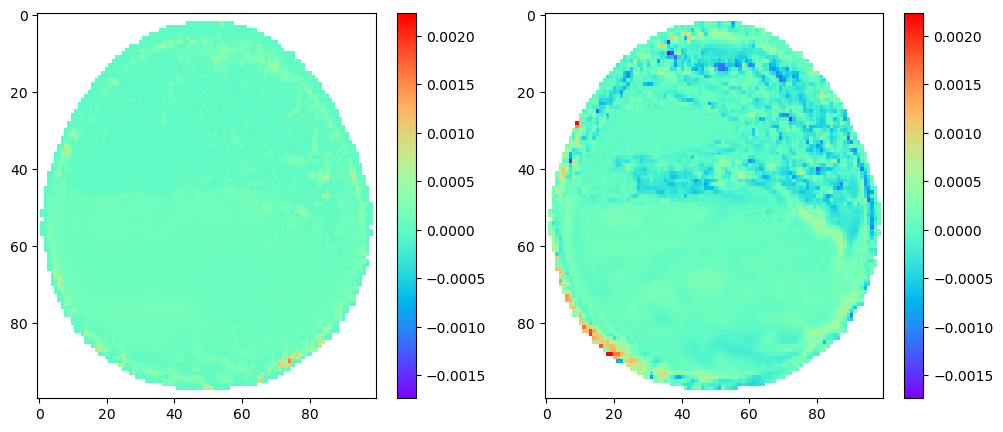

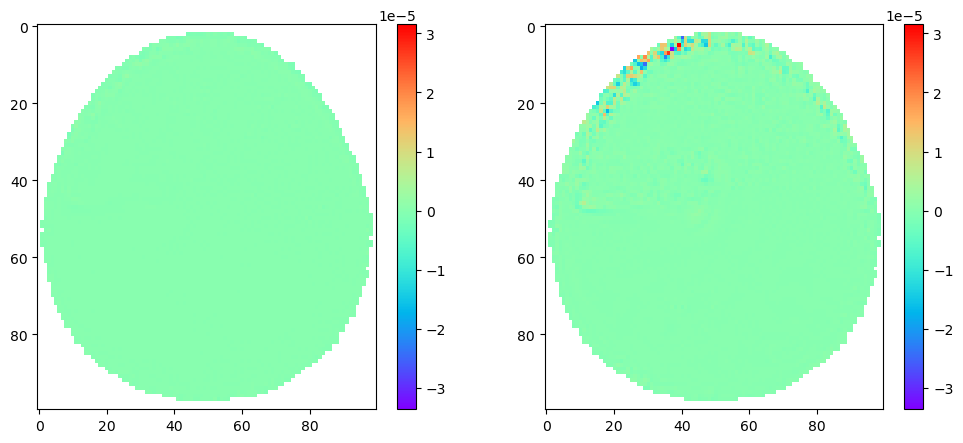

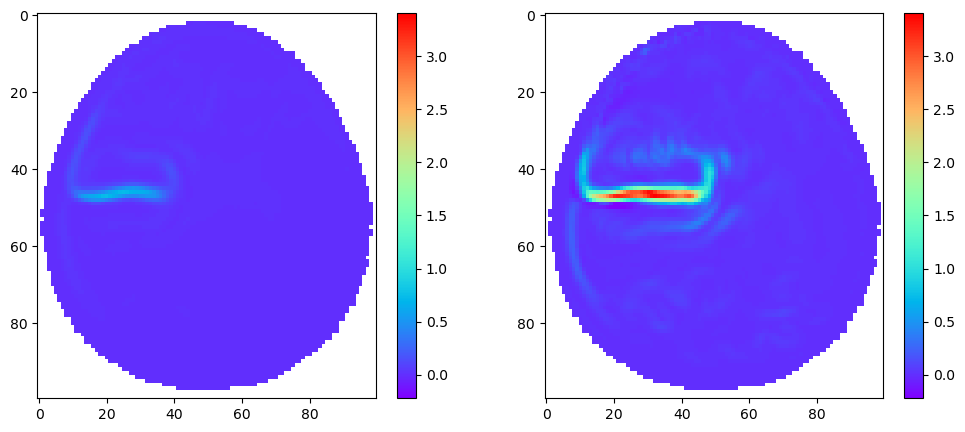

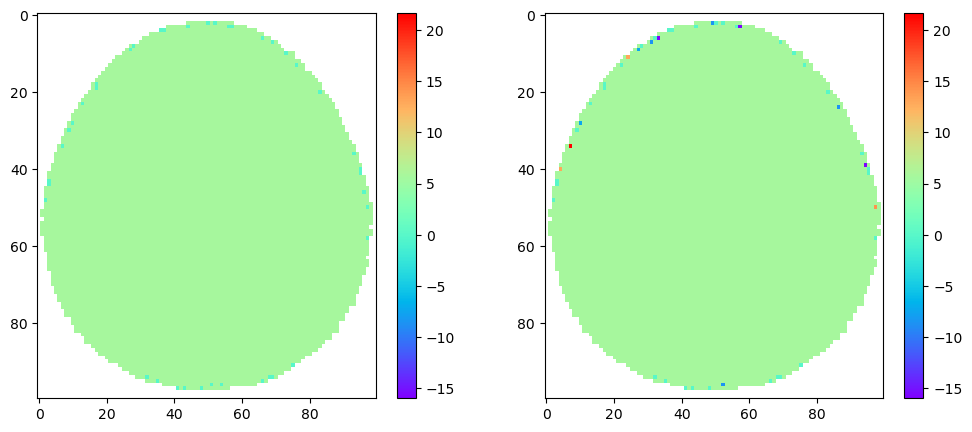

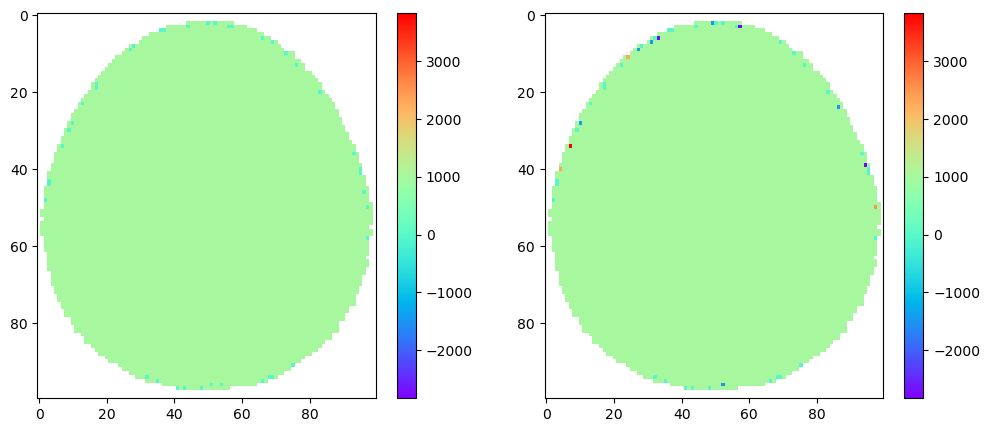

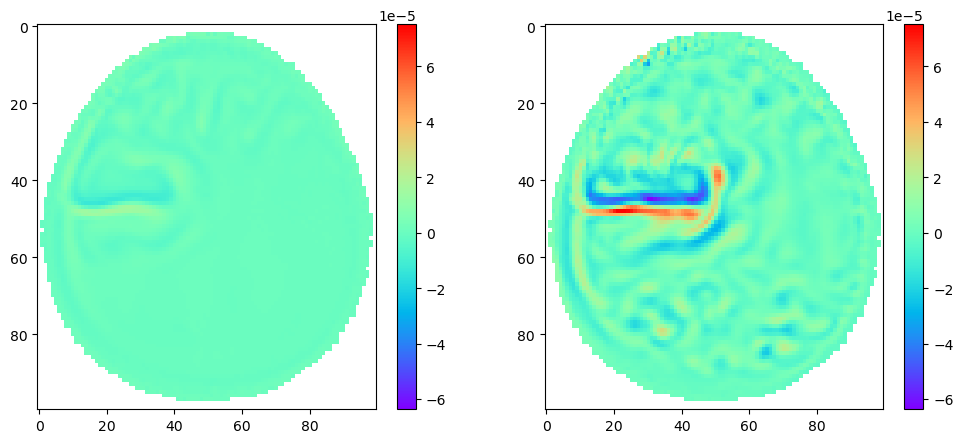

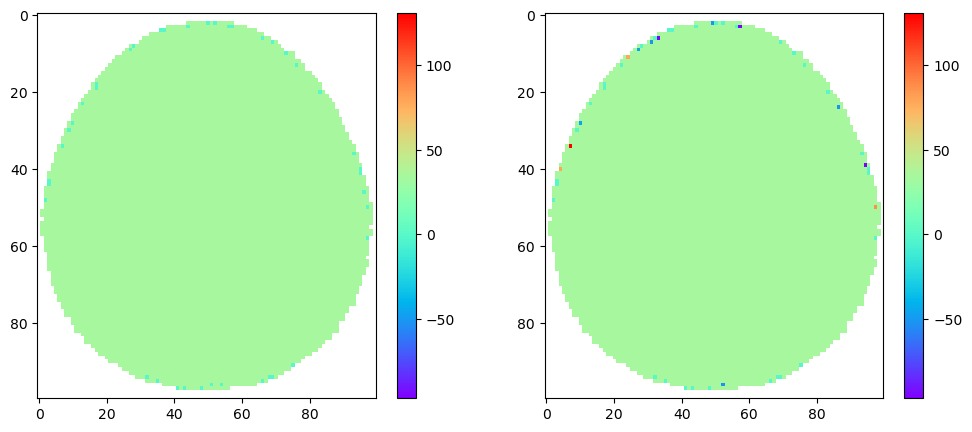

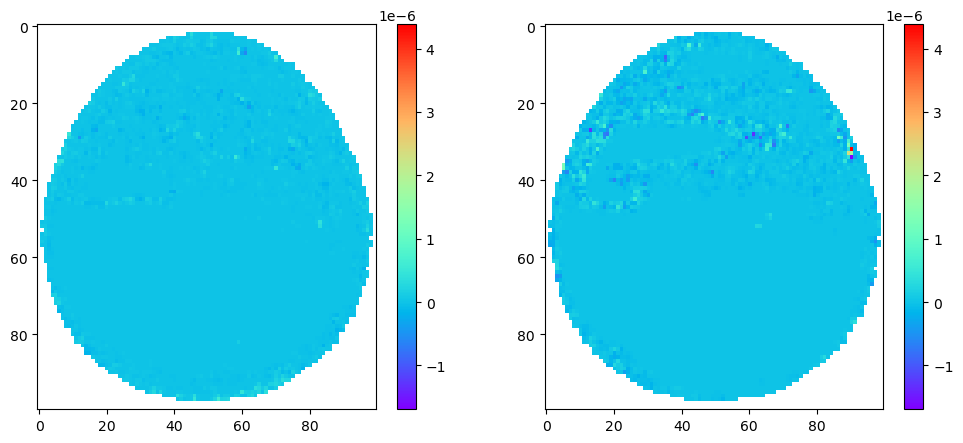

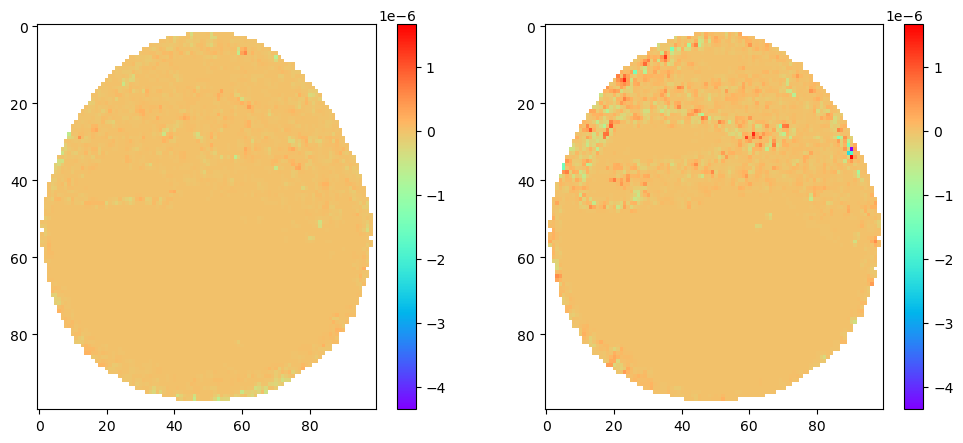

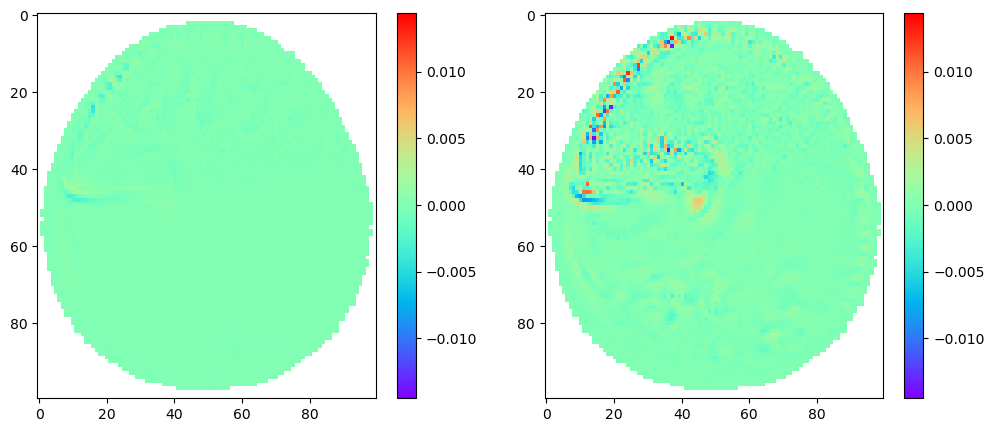

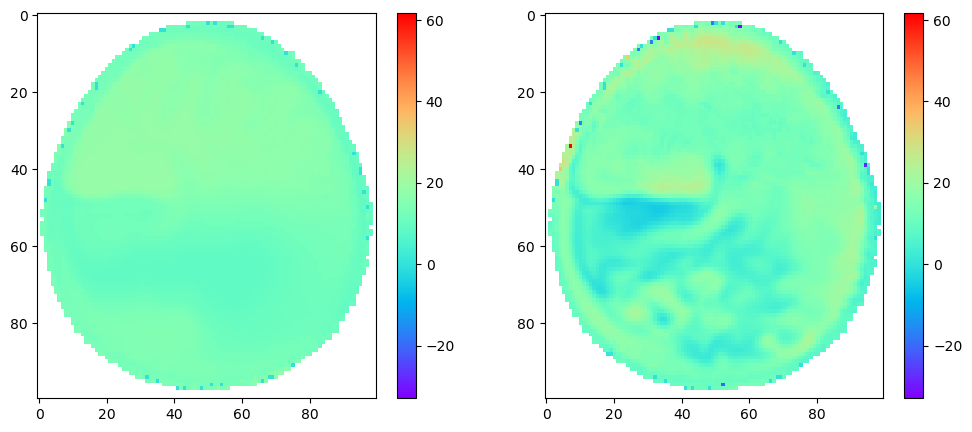

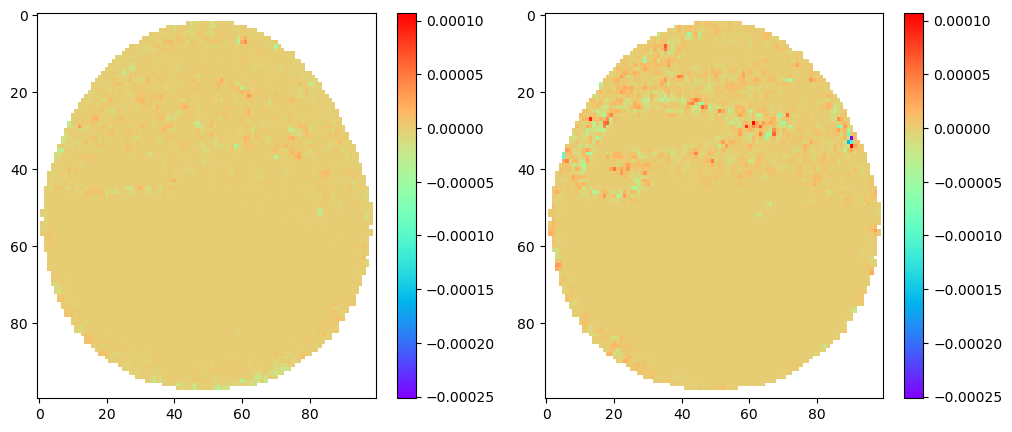

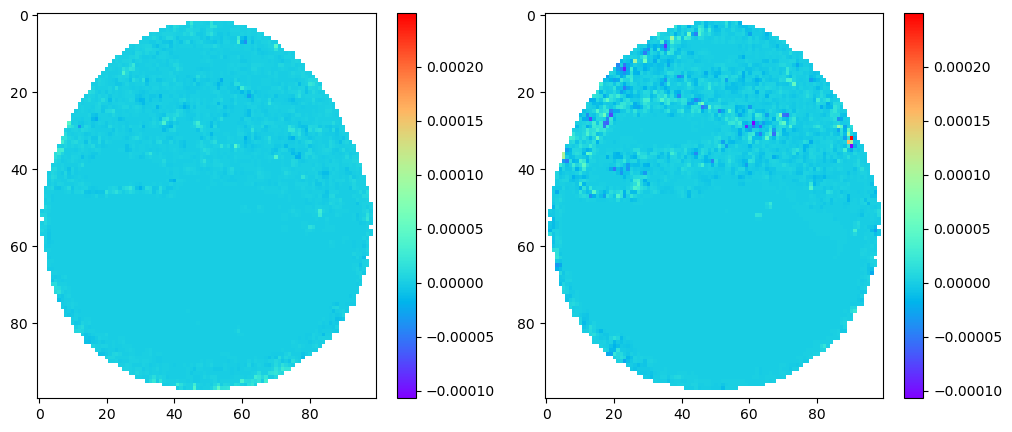

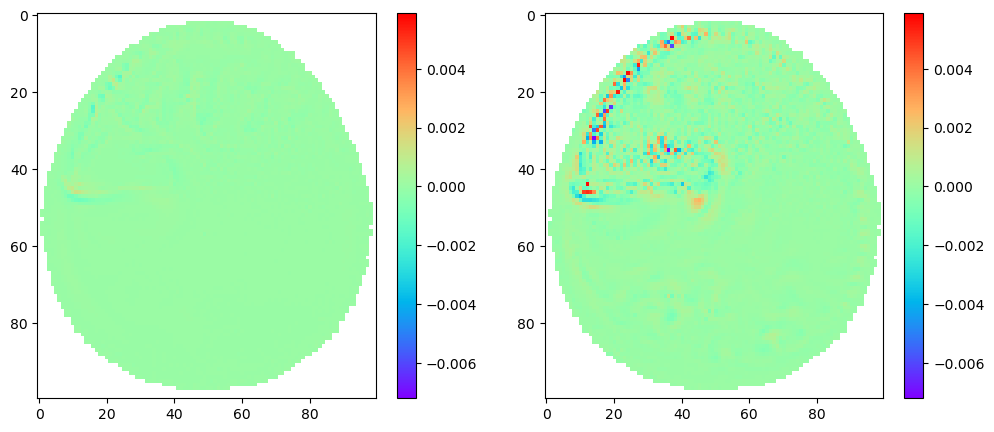

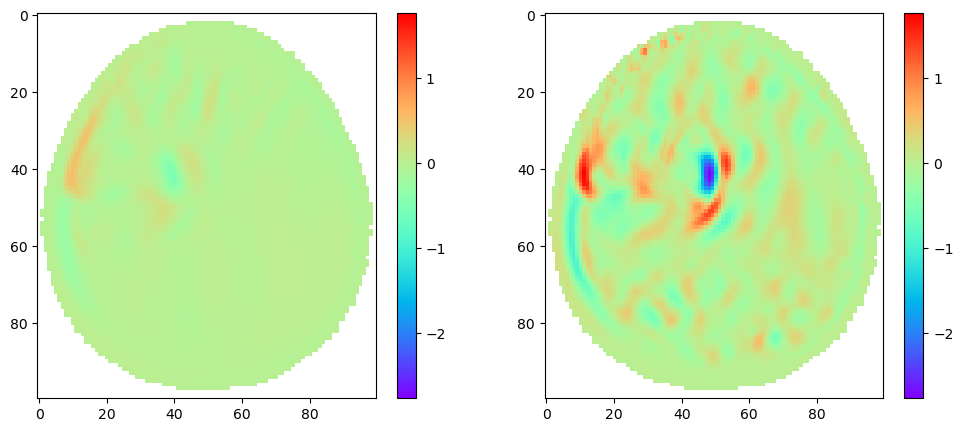

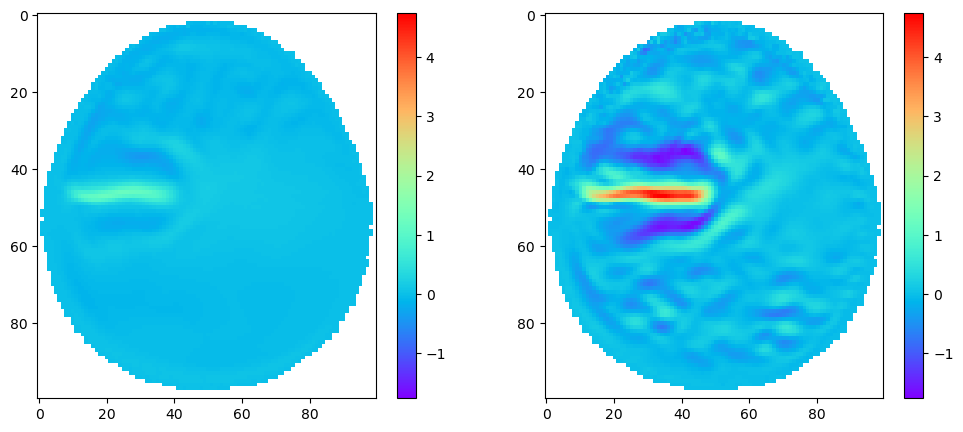

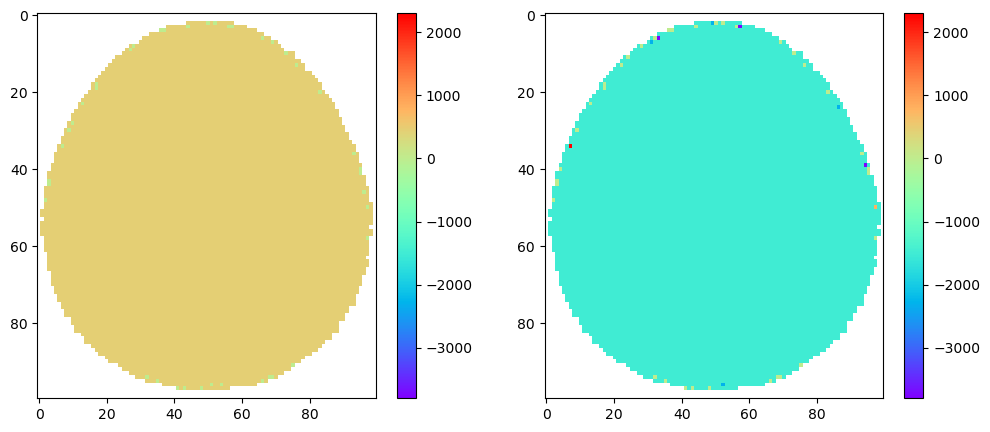

In [11]:
for i in range(17):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    mask = np.squeeze(mask).astype(bool)
    true = data_test[0,20,:,:,i]
    transformed = data_test_inverse[0,20,:,:,i]
    true[~mask] = np.nan
    transformed[~mask] = np.nan

    vmax = np.max([np.nanmax(data_test[0,20,:,:,i]), np.nanmax(data_test_inverse[0,20,:,:,i])] )
    vmin = np.min([np.nanmin(data_test[0,20,:,:,i]), np.nanmin(data_test_inverse[0,20,:,:,i])] )
    im = ax[0].imshow(true, cmap='rainbow', aspect='auto', vmin=vmin, vmax=vmax)
    im2 = ax[1].imshow(transformed, cmap='rainbow',  aspect='auto', vmin=vmin, vmax=vmax)
    # for a in ax:
    #     a.set_box_aspect(1)
    fig.colorbar(im)
    fig.colorbar(im2)

    plt.show()